In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
df = pd.read_csv('../data/weblogs1.csv')
df.head()

,ID,NUMBER_OF_REQUESTS,TOTAL_DURATION,AVERAGE_TIME,STANDARD_DEVIATION,REPEATED_REQUESTS,HTTP_RESPONSE_2XX,HTTP_RESPONSE_3XX,HTTP_RESPONSE_4XX,HTTP_RESPONSE_5XX,...,DEPTH,STD_DEPTH,CONSECUTIVE,DATA,PPI,SF_REFERRER,SF_FILETYPE,MAX_BARRAGE,PENALTY,ROBOT
0,obSnwGoBCue8G08E_WCX,79,592,7.589744,1.800540,0.000000,0.873418,0.126582,0.000000,0.000000,...,4.0,0.494041,0.101266,1555089.0,2.718334e+07,0.000000,0.205128,1,0,1
1,nLSnwGoBCue8G08E_WCX,350,103621,296.908300,260.332670,0.000000,0.997143,0.000000,0.002857,0.000000,...,6.0,0.341303,0.425714,2071344.0,1.427714e+01,0.547278,0.461318,4,0,1
2,ErSowGoBCue8G08ECmHa,15,368,26.285715,87.329780,0.000000,1.000000,0.000000,0.000000,0.000000,...,3.0,0.000000,0.000000,49505.0,1.413333e+01,0.642857,1.000000,2,0,0
3,E7SowGoBCue8G08ECmHa,28,11,0.407407,1.097447,0.000000,1.000000,0.000000,0.000000,0.000000,...,3.0,0.000000,0.821429,45984.0,1.332143e+01,0.037037,0.148148,5,0,0
4,FbSowGoBCue8G08ECmHa,9342,80946,8.665668,17.566462,0.000107,0.996896,0.002569,0.000214,0.000321,...,4.0,0.152943,0.953757,83171793.0,1.307407e+01,0.000000,0.023552,1,0,1


ID droppen

In [9]:
df = df.drop(['ID'], axis=1)

Opsplitsen in X en y

In [10]:
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33676 entries, 0 to 33675
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   NUMBER_OF_REQUESTS  33676 non-null  int64  
 1   TOTAL_DURATION      33676 non-null  int64  
 2   AVERAGE_TIME        33676 non-null  float64
 3   STANDARD_DEVIATION  26846 non-null  float64
 4   REPEATED_REQUESTS   33676 non-null  float64
 5   HTTP_RESPONSE_2XX   33676 non-null  float64
 6   HTTP_RESPONSE_3XX   33676 non-null  float64
 7   HTTP_RESPONSE_4XX   33676 non-null  float64
 8   HTTP_RESPONSE_5XX   33676 non-null  float64
 9   GET_METHOD          33676 non-null  float64
 10  POST_METHOD         33676 non-null  float64
 11  HEAD_METHOD         33676 non-null  float64
 12  OTHER_METHOD        33676 non-null  float64
 13  NIGHT               33676 non-null  float64
 14  UNASSIGNED          33676 non-null  float64
 15  IMAGES              33676 non-null  float64
 16  TOTA

STANDARD_DEVIATION,  SF_FILETYPE en SF_REFERRER --> hebben NaN waarden

Opvullen met 0, opvullen met mean() of weglaten

### Opvullen met 0
en vergelijken met std()

In [12]:
X.std()

NUMBER_OF_REQUESTS    2.019290e+02
TOTAL_DURATION        8.362284e+03
AVERAGE_TIME          1.464994e+02
STANDARD_DEVIATION    8.796564e+01
REPEATED_REQUESTS     7.946920e-02
HTTP_RESPONSE_2XX     1.162992e-01
HTTP_RESPONSE_3XX     6.388766e-02
HTTP_RESPONSE_4XX     9.273549e-02
HTTP_RESPONSE_5XX     3.127461e-02
GET_METHOD            5.476387e-02
POST_METHOD           2.869352e-02
HEAD_METHOD           4.623714e-02
OTHER_METHOD          7.730190e-03
NIGHT                 2.566460e-01
UNASSIGNED            4.206386e-01
IMAGES                3.029098e-01
TOTAL_HTML            3.501775e-01
HTML_TO_IMAGE         5.105739e+00
HTML_TO_CSS           1.379890e+00
HTML_TO_JS            2.722013e+00
WIDTH                 1.809591e+02
DEPTH                 1.509038e+00
STD_DEPTH             5.983012e-01
CONSECUTIVE           2.788597e-01
DATA                  2.330374e+06
PPI                   3.734383e+07
SF_REFERRER           2.428942e-01
SF_FILETYPE           2.453545e-01
MAX_BARRAGE         

In [13]:
X_zero = X.copy()
X_zero = X.fillna(0)
X_zero.std()

NUMBER_OF_REQUESTS    2.019290e+02
TOTAL_DURATION        8.362284e+03
AVERAGE_TIME          1.464994e+02
STANDARD_DEVIATION    8.014122e+01
REPEATED_REQUESTS     7.946920e-02
HTTP_RESPONSE_2XX     1.162992e-01
HTTP_RESPONSE_3XX     6.388766e-02
HTTP_RESPONSE_4XX     9.273549e-02
HTTP_RESPONSE_5XX     3.127461e-02
GET_METHOD            5.476387e-02
POST_METHOD           2.869352e-02
HEAD_METHOD           4.623714e-02
OTHER_METHOD          7.730190e-03
NIGHT                 2.566460e-01
UNASSIGNED            4.206386e-01
IMAGES                3.029098e-01
TOTAL_HTML            3.501775e-01
HTML_TO_IMAGE         5.105739e+00
HTML_TO_CSS           1.379890e+00
HTML_TO_JS            2.722013e+00
WIDTH                 1.809591e+02
DEPTH                 1.509038e+00
STD_DEPTH             5.983012e-01
CONSECUTIVE           2.788597e-01
DATA                  2.330374e+06
PPI                   3.734383e+07
SF_REFERRER           2.413764e-01
SF_FILETYPE           2.683445e-01
MAX_BARRAGE         

Bij STANDARD_DEVIATION is er bijna een verschil van 1.0 bij de std()

Bij SF_REFERRER is er maar een verschil van ongv. 0.025

Bij SF_FILETYPE zien we een verschil van ongv. 0.225

Dit lijkt mij een te grote afwijking --> fillna(X.mean()) testen

### Opvullen met mean()

In [14]:
X_mean = X.copy()
X_mean = X.fillna(X.mean())
X.std()

NUMBER_OF_REQUESTS    2.019290e+02
TOTAL_DURATION        8.362284e+03
AVERAGE_TIME          1.464994e+02
STANDARD_DEVIATION    8.796564e+01
REPEATED_REQUESTS     7.946920e-02
HTTP_RESPONSE_2XX     1.162992e-01
HTTP_RESPONSE_3XX     6.388766e-02
HTTP_RESPONSE_4XX     9.273549e-02
HTTP_RESPONSE_5XX     3.127461e-02
GET_METHOD            5.476387e-02
POST_METHOD           2.869352e-02
HEAD_METHOD           4.623714e-02
OTHER_METHOD          7.730190e-03
NIGHT                 2.566460e-01
UNASSIGNED            4.206386e-01
IMAGES                3.029098e-01
TOTAL_HTML            3.501775e-01
HTML_TO_IMAGE         5.105739e+00
HTML_TO_CSS           1.379890e+00
HTML_TO_JS            2.722013e+00
WIDTH                 1.809591e+02
DEPTH                 1.509038e+00
STD_DEPTH             5.983012e-01
CONSECUTIVE           2.788597e-01
DATA                  2.330374e+06
PPI                   3.734383e+07
SF_REFERRER           2.428942e-01
SF_FILETYPE           2.453545e-01
MAX_BARRAGE         

Hier zien we nog een grotere afwijking --> Features met Nan-Values droppen

### Features met Nan-values droppen

In [15]:
X_drop = X.copy()
X_drop = X.drop(['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE'], axis=1)

### Train en test opsplitsen voor alle soorten X (zero, mean, drop)

In [16]:
X_zero_train, X_zero_test, y_train, y_test = train_test_split(X_zero, y, test_size=0.2, random_state=42)

print(X_zero_train.shape, X_zero_test.shape, y_train.shape, y_test.shape)

(26940, 30) (6736, 30) (26940,) (6736,)


In [17]:
X_mean_train, X_mean_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)

print(X_mean_train.shape, X_mean_test.shape, y_train.shape, y_test.shape)

(26940, 30) (6736, 30) (26940,) (6736,)


In [18]:
X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

print(X_drop_train.shape, X_drop_test.shape, y_train.shape, y_test.shape)

(26940, 27) (6736, 27) (26940,) (6736,)


# DecisionTreeClassifier trainen en testen

#### DecisionTreeClassifier best estimator zoeken met grid search cv

##### X_zero

In [19]:
grid_search_zero = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, scoring='accuracy', return_train_score=True)

grid_search_zero.fit(X_zero_train, y_train)

print(grid_search_zero.best_params_)
print("\n")

y_pred_0 = grid_search_zero.predict(X_zero_test)

print(accuracy_score(y_test, y_pred_0))
print("\n")

print(classification_report(y_test, y_pred_0))
print("\n")

cm_0 = confusion_matrix(y_test, y_pred_0)

print(cm_0)
print("\n")

{'max_depth': 13}


0.9766923990498813


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5393
           1       0.94      0.94      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736



[[5316   77]
 [  80 1263]]




##### X_mean

In [20]:
grid_search_mean = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, scoring='accuracy', return_train_score=True)

grid_search_mean.fit(X_mean_train, y_train)

print(grid_search_mean.best_params_)
print("\n")

y_pred_mean = grid_search_mean.predict(X_mean_test)

print(accuracy_score(y_test, y_pred_mean))
print("\n")

print(classification_report(y_test, y_pred_mean))
print("\n")

cm_mean = confusion_matrix(y_test, y_pred_mean)

print(cm_mean)
print("\n")

{'max_depth': 12}


0.9756532066508313


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5393
           1       0.94      0.93      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736



[[5317   76]
 [  88 1255]]




##### X_drop

In [21]:
grid_search_drop = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, scoring='accuracy', return_train_score=True)

grid_search_drop.fit(X_drop_train, y_train)

print(grid_search_drop.best_params_)
print("\n")

y_pred_drop = grid_search_drop.predict(X_drop_test)

print(accuracy_score(y_test, y_pred_drop))
print("\n")

print(classification_report(y_test, y_pred_drop))
print("\n")

cm_drop = confusion_matrix(y_test, y_pred_drop)

print(cm_drop)
print("\n")

{'max_depth': 13}


0.9759501187648456


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5393
           1       0.94      0.94      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736



[[5312   81]
 [  81 1262]]




Geen groot verschil tussen de 3 verschillende X'en

### Feature Importance bekijken

In [22]:
features_0 = X_zero.columns

dt_clf_0 = DecisionTreeClassifier(random_state=42, max_depth=17)
dt_clf_0.fit(X_zero_train, y_train)

importances_0 = dt_clf_0.feature_importances_

df_importances_0 = pd.DataFrame({'feature': features_0, 'importance': importances_0})
df_importances_0 = df_importances_0.sort_values(by='importance', ascending=False)
df_importances_0

,feature,importance
14,UNASSIGNED,0.697900
24,DATA,0.077182
29,PENALTY,0.036227
15,IMAGES,0.033336
21,DEPTH,0.024546
7,HTTP_RESPONSE_4XX,0.024233
25,PPI,0.020710
16,TOTAL_HTML,0.020474
2,AVERAGE_TIME,0.012643
1,TOTAL_DURATION,0.011410


In [23]:
features_m = X_mean.columns

dt_clf_m = DecisionTreeClassifier(random_state=42)
dt_clf_m.fit(X_mean_train, y_train)

importances_m = dt_clf_m.feature_importances_

df_importances_m = pd.DataFrame({'feature': features_m, 'importance': importances_m})
df_importances_m = df_importances_m.sort_values(by='importance', ascending=False)
df_importances_m

,feature,importance
14,UNASSIGNED,0.679694
24,DATA,0.095055
29,PENALTY,0.035292
15,IMAGES,0.032351
21,DEPTH,0.024613
7,HTTP_RESPONSE_4XX,0.023607
25,PPI,0.022286
16,TOTAL_HTML,0.020031
2,AVERAGE_TIME,0.014894
1,TOTAL_DURATION,0.008743


In [24]:
features_d = X_drop.columns

dt_clf_d = DecisionTreeClassifier(random_state=42)
dt_clf_d.fit(X_drop_train, y_train)

importances_d = dt_clf_d.feature_importances_

df_importances_d = pd.DataFrame({'feature': features_d, 'importance': importances_d})
df_importances_d = df_importances_d.sort_values(by='importance', ascending=False)
df_importances_d

,feature,importance
13,UNASSIGNED,0.679694
23,DATA,0.097977
26,PENALTY,0.035292
14,IMAGES,0.032604
20,DEPTH,0.023943
6,HTTP_RESPONSE_4XX,0.023607
24,PPI,0.021882
15,TOTAL_HTML,0.021127
2,AVERAGE_TIME,0.014896
1,TOTAL_DURATION,0.011335


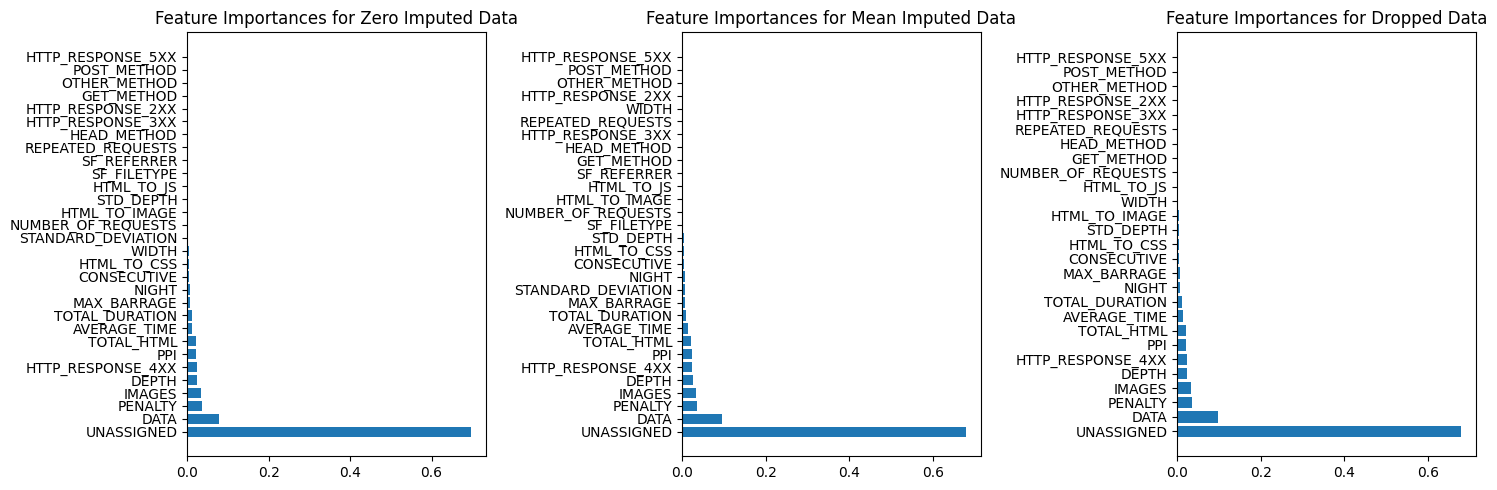

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].barh(df_importances_0['feature'], df_importances_0['importance'])
ax[0].set_title('Feature Importances for Zero Imputed Data')

ax[1].barh(df_importances_m['feature'], df_importances_m['importance'])
ax[1].set_title('Feature Importances for Mean Imputed Data')

ax[2].barh(df_importances_d['feature'], df_importances_d['importance'])
ax[2].set_title('Feature Importances for Dropped Data')

plt.tight_layout()
plt.show()

Duidelijk dat OTHER_METHOD, POST_METHOD, HEAD_METHOD, HTTP_RESPONSE(3,4,5)XX en REPEATED_REQUESTS geen importance hebben --> droppen

In [26]:
X_zero = X.copy()
X_zero = X_zero.fillna(0)
X_zero = X_zero.drop(['OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_mean = X.copy()
X_mean = X_mean.fillna(0)
X_mean = X_mean.drop(['OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

X_drop = X.copy()
X_drop = X.drop(['STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)

### Accuracy, confusion matrix en classification report vergelijken na het droppen

In [27]:
X_zero_train, X_zero_test, y_train, y_test = train_test_split(X_zero, y, test_size=0.2, random_state=42)

print(X_zero_train.shape, X_zero_test.shape, y_train.shape, y_test.shape)

(26940, 23) (6736, 23) (26940,) (6736,)


In [28]:
X_mean_train, X_mean_test, y_train, y_test = train_test_split(X_mean, y, test_size=0.2, random_state=42)

print(X_mean_train.shape, X_mean_test.shape, y_train.shape, y_test.shape)

(26940, 23) (6736, 23) (26940,) (6736,)


In [29]:
X_drop_train, X_drop_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2, random_state=42)

print(X_drop_train.shape, X_drop_test.shape, y_train.shape, y_test.shape)

(26940, 20) (6736, 20) (26940,) (6736,)


### X zero

{'max_depth': 12}


0.9755047505938242


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5393
           1       0.94      0.94      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736





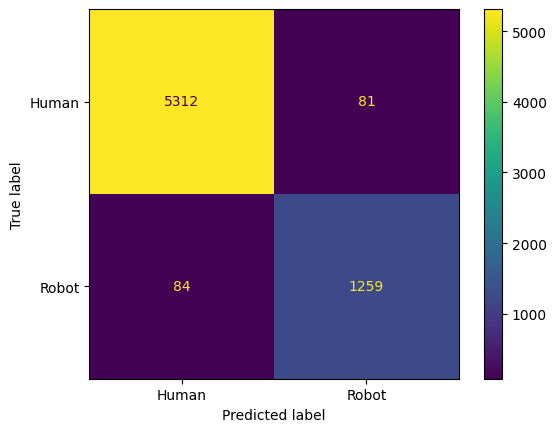

In [30]:
grid_search_zero = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, scoring='accuracy', return_train_score=True)

grid_search_zero.fit(X_zero_train, y_train)

print(grid_search_zero.best_params_)
print("\n")

y_pred_0 = grid_search_zero.predict(X_zero_test)

print(accuracy_score(y_test, y_pred_0))
print("\n")

print(classification_report(y_test, y_pred_0))
print("\n")

cm_0 = confusion_matrix(y_test, y_pred_0)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_0, display_labels=['Human', 'Robot'])
disp.plot()

### X mean

{'max_depth': 12}


0.9755047505938242


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5393
           1       0.94      0.94      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736





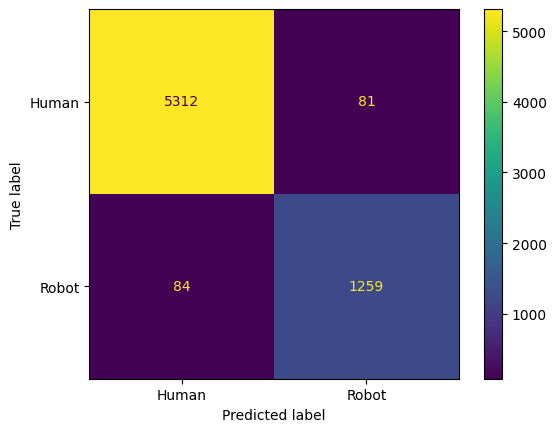

In [31]:
grid_search_mean = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, scoring='accuracy', return_train_score=True)

grid_search_mean.fit(X_mean_train, y_train)

print(grid_search_mean.best_params_)
print("\n")

y_pred_mean = grid_search_mean.predict(X_mean_test)

print(accuracy_score(y_test, y_pred_mean))
print("\n")

print(classification_report(y_test, y_pred_mean))
print("\n")

cm_mean = confusion_matrix(y_test, y_pred_mean)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=['Human', 'Robot'])
disp.plot()

### X drop

{'max_depth': 12}


0.9749109263657957


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5393
           1       0.94      0.94      0.94      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.97      0.97      0.97      6736





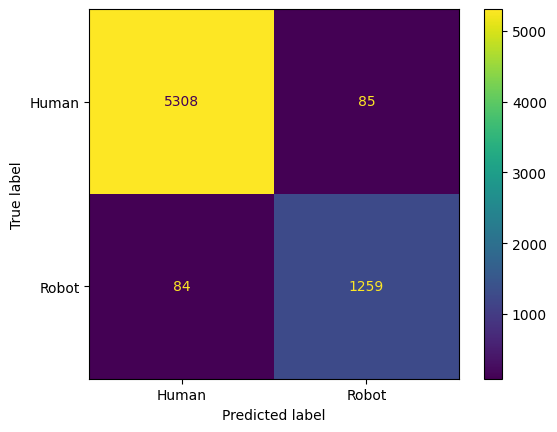

In [32]:
grid_search_drop = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={'max_depth': np.arange(2, 31)}, cv=5, scoring='accuracy', return_train_score=True)

grid_search_drop.fit(X_drop_train, y_train)

print(grid_search_drop.best_params_)
print("\n")

y_pred_drop = grid_search_drop.predict(X_drop_test)

print(accuracy_score(y_test, y_pred_drop))
print("\n")

print(classification_report(y_test, y_pred_drop))
print("\n")

cm_drop = confusion_matrix(y_test, y_pred_drop)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_drop, display_labels=['Human', 'Robot'])
disp.plot()

Aangezien de verschillen zeer minimaal zijn tussen de X_zero, X_mean en X_drop resultaten en de STD() te veel afwijkten bij de X_zero en X_meam ga ik de X_drop gebruiken. Ook bij de Feature importance kan er gezien worden dat STANDARD_DEVIATION, SF_REFERRER EN SF_FILETYPE nauwelijks impact (importance) hebben

## DecisionTreeClassifier resultaten vergelijken met BaggingClassifier (Met en zonder OOB), met AdaBoostClassifier, GradientBoostClassifier en RandomForestClassifier

De ranges van de waarden bij de features verschillen soms erg veel (De number of request bvb kan oplopen tot een nummer groter dan 9000 terwijl er bij de HTTP_REQUEST soms getallen van 0.3 zijn) --> testen of de models betere resultaten geven wanneer features gescaled zijn

In [33]:
df = pd.read_csv('../data/weblogs1.csv')

df = df.drop(['ID', 'STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

corr_matrix = df.corr()
corr_matrix['ROBOT'].sort_values(ascending=True)

DEPTH                -0.425615
STD_DEPTH            -0.396751
MAX_BARRAGE          -0.364051
CONSECUTIVE          -0.338921
HTML_TO_IMAGE        -0.301658
HTML_TO_CSS          -0.256439
HTML_TO_JS           -0.247344
PENALTY              -0.150441
NUMBER_OF_REQUESTS   -0.044259
WIDTH                -0.044049
IMAGES               -0.022613
GET_METHOD           -0.014206
HTTP_RESPONSE_2XX    -0.000953
PPI                   0.057544
TOTAL_DURATION        0.081283
DATA                  0.122371
NIGHT                 0.208905
TOTAL_HTML            0.236839
AVERAGE_TIME          0.263035
UNASSIGNED            0.803059
ROBOT                 1.000000
Name: ROBOT, dtype: float64

We zien dat "HTTP_RESPONSE_2XX" en "GET_METHOD" een zeer lage correlatie hebben met ROBOT --> laten deze vallen

In [34]:
X = X.drop(['HTTP_RESPONSE_2XX', "GET_METHOD"], axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26940, 18) (6736, 18) (26940,) (6736,)


### Zonder scaling

##### DecisionTreeClassifier

{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 8}


0.9755047505938242


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5393
           1       0.94      0.93      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736



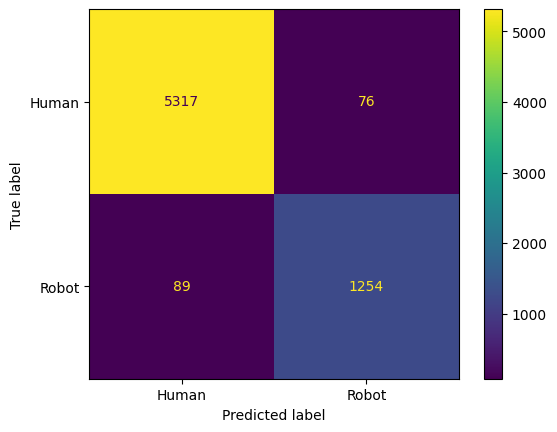

In [36]:
param_grid_dtc = {'max_depth': np.arange(2, 19), 'min_samples_split': np.arange(2, 11, 2), 'min_samples_leaf': np.arange(1, 12, 2)}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid_dtc, cv=5, scoring='precision', return_train_score=True)

grid_search_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
print("\n")

dt_clf = grid_search_dtc.best_estimator_

dt_clf.fit(X_train, y_train)

y_pred_dtc = dt_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_dtc))
print("\n")
print(classification_report(y_test, y_pred_dtc))

cm = confusion_matrix(y_test, y_pred_dtc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### BaggingClassifier zonder OOB

- n_estimators = 500 --> 500 decision trees getrained op subset vd data
- max_samples = 100 --> elke tree zal op 100 samples v/e random subset worden getrained
- bootstrap = True --> training data samples zullen replaced worden

0.9557600950118765


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5393
           1       0.87      0.92      0.89      1343

    accuracy                           0.96      6736
   macro avg       0.92      0.94      0.93      6736
weighted avg       0.96      0.96      0.96      6736



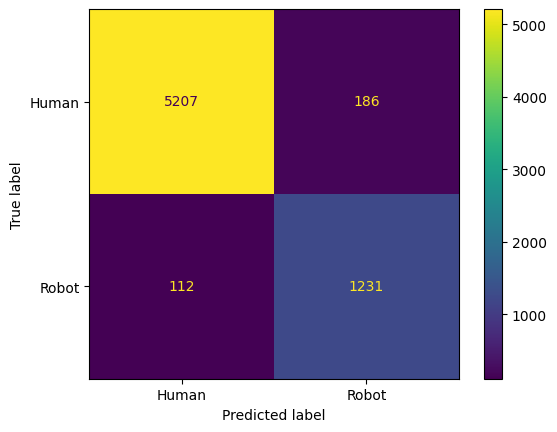

In [37]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

y_pred_bc = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_bc))
print("\n")
print(classification_report(y_test, y_pred_bc))

cm = confusion_matrix(y_test, y_pred_bc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### BaggingClassifier met OOB

- oob_score = True --> niet gebruikte data samples voor evaluatie BaggingClassifier

In [38]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9531180400890868

In [39]:
y_pred_oob = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred_oob)

0.9557600950118765

Is zeer dicht bij de OOB score

In [40]:
print(classification_report(y_test, y_pred_oob))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5393
           1       0.87      0.92      0.89      1343

    accuracy                           0.96      6736
   macro avg       0.92      0.94      0.93      6736
weighted avg       0.96      0.96      0.96      6736



##### AdaBoostClassifier

0.9734263657957245

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5393
           1       0.94      0.92      0.93      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.95      0.96      6736
weighted avg       0.97      0.97      0.97      6736



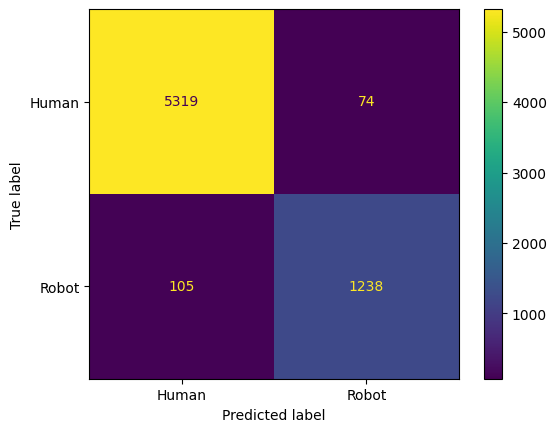

In [41]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_ada)}\n")

print(classification_report(y_test, y_pred_ada))

cm = confusion_matrix(y_test, y_pred_ada)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### GradientBoostClassifier

best_n_estimators --> list van MSE's --> kiezen index met laagste (minimum) MSE en + 1 omdat index op 0 start

0.9769893111638955

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5393
           1       0.95      0.93      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.97      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736



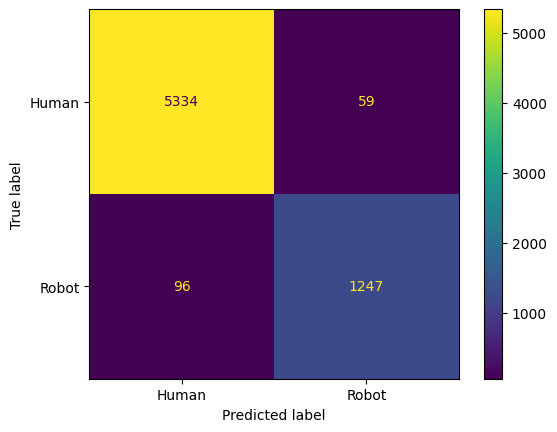

In [42]:
gbrt = GradientBoostingClassifier(max_depth=18, n_estimators=120, learning_rate=0.1, random_state=42)
gbrt.fit(X_train, y_train)

errors_gbrt = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

best_n_estimators = np.argmin(errors_gbrt) + 1

gbrt_best = GradientBoostingClassifier(max_depth=18, n_estimators=best_n_estimators, learning_rate=0.1, random_state=42)
gbrt_best.fit(X_train, y_train)

y_pred_gbrt = gbrt_best.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_gbrt)}\n")

print(classification_report(y_test, y_pred_gbrt))

cm = confusion_matrix(y_test, y_pred_gbrt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### RandomForestClassifier

{'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}
0.9768408551068883

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5393
           1       0.95      0.93      0.94      1343

    accuracy                           0.98      6736
   macro avg       0.97      0.96      0.96      6736
weighted avg       0.98      0.98      0.98      6736



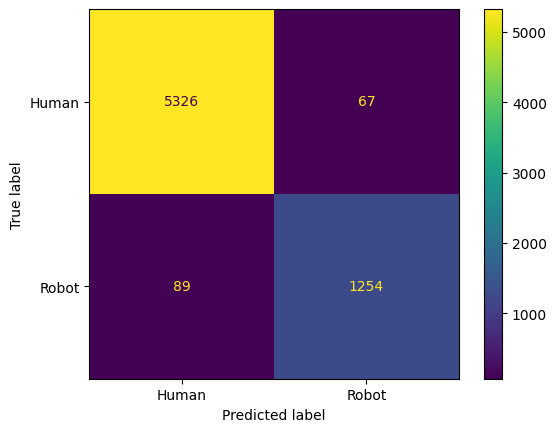

In [43]:
param_grid = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [1, 2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 5, 10],
}

grid_search_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)

grid_search_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_)

rf_clf = grid_search_rfc.best_estimator_
rf_clf.fit(X_train, y_train)

y_pred_rfc = rf_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_rfc)}\n")

print(classification_report(y_test, y_pred_rfc))

cm = confusion_matrix(y_test, y_pred_rfc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

### Met Scaling

In [44]:
df = pd.read_csv('../data/weblogs1.csv')

X = df.drop(['ROBOT', 'ID', 'STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)
y = df['ROBOT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0.9719418052256532

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5393
           1       0.93      0.93      0.93      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.97      0.97      0.97      6736



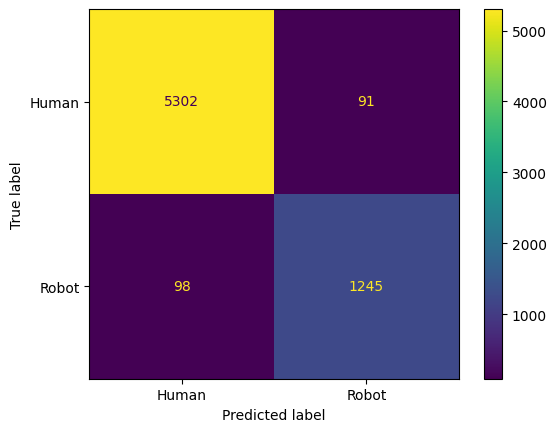

In [45]:
from sklearn.pipeline import Pipeline

scaler = StandardScaler()

dt_clf_scaled = DecisionTreeClassifier(random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('gs_dt_clf_scaled', GridSearchCV(dt_clf_scaled, param_grid=param_grid_dtc, cv=5, n_jobs=-1)),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = confusion_matrix(y_test, y_pred_pipeline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

0.9547209026128266

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5393
           1       0.86      0.92      0.89      1343

    accuracy                           0.95      6736
   macro avg       0.92      0.94      0.93      6736
weighted avg       0.96      0.95      0.96      6736



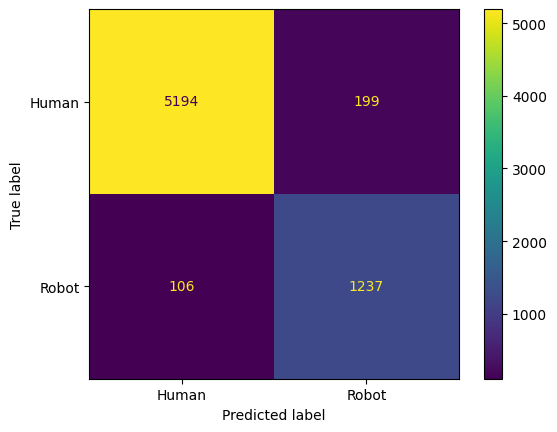

In [46]:
bag_clf_scaled = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('bag_clf_scaled', bag_clf_scaled),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = confusion_matrix(y_test, y_pred_pipeline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

0.9547209026128266

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5393
           1       0.86      0.92      0.89      1343

    accuracy                           0.95      6736
   macro avg       0.92      0.94      0.93      6736
weighted avg       0.96      0.95      0.96      6736



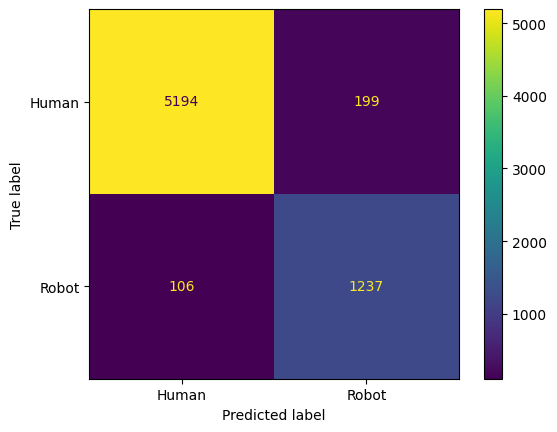

In [47]:
bag_clf_oob_scaled = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('bag_clf_oob_scaled', bag_clf_oob_scaled),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = confusion_matrix(y_test, y_pred_pipeline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

0.9726840855106889

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5393
           1       0.94      0.92      0.93      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.95      0.96      6736
weighted avg       0.97      0.97      0.97      6736



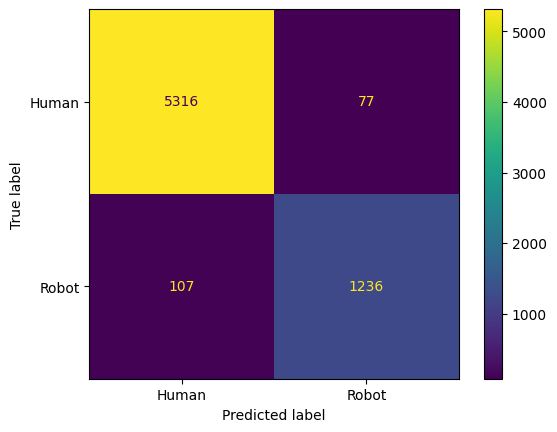

In [48]:
ada_clf_scaled = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('ada_clf_scaled', ada_clf_scaled),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = confusion_matrix(y_test, y_pred_pipeline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

0.9719418052256532

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5393
           1       0.95      0.91      0.93      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.95      0.96      6736
weighted avg       0.97      0.97      0.97      6736



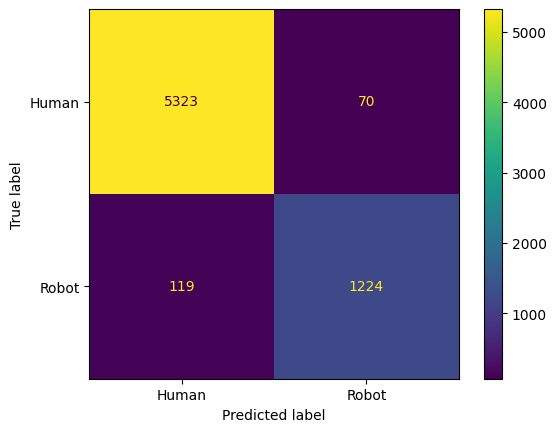

In [49]:
gbrt_best_scaled = GradientBoostingClassifier(max_depth=18, n_estimators=best_n_estimators, learning_rate=0.1, random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('gbrt_best_scaled', gbrt_best_scaled),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = confusion_matrix(y_test, y_pred_pipeline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

0.9722387173396675

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5393
           1       0.93      0.94      0.93      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.96      0.96      6736
weighted avg       0.97      0.97      0.97      6736



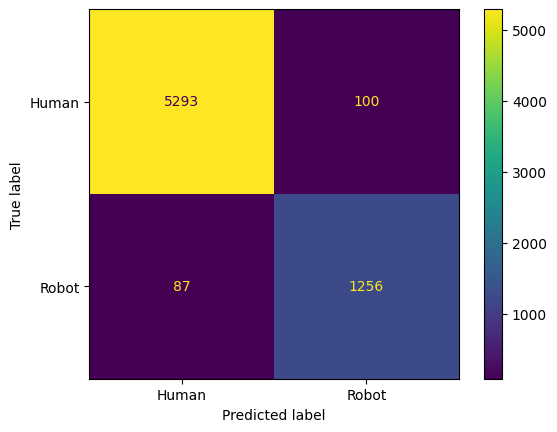

In [50]:
rf_clf_scaled = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('rf_clf_scaled', GridSearchCV(rf_clf_scaled, param_grid=param_grid, cv=5, n_jobs=-1)),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = confusion_matrix(y_test, y_pred_pipeline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

Conclusie --> scaling heeft de resultaten slechter gemaakt

### Models opslaan

In [52]:
filename = '../main_models/decision_tree_classifier1.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

filename2 = '../main_models/bagging_classifier_oob1.sav'
pickle.dump(bag_clf, open(filename2, 'wb'))

filename3 = '../main_models/adaboost_classifier1.sav'
pickle.dump(ada_clf, open(filename3, 'wb'))

filename4 = '../main_models/gradient_boosting_classifier1.sav'
pickle.dump(gbrt_best, open(filename4, 'wb'))

filename5 = '../main_models/random_forest_classifier1.sav'
pickle.dump(rf_clf, open(filename5, 'wb'))